In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rcParams
from matplotlib import rcParamsDefault
from matplotlib.colors import ListedColormap
import pprint
import pandas as pd

cmap = plt.get_cmap('cividis') # This is good but too green
lower_limit = 0
upper_limit = 0.85
new_cmap = cmap(np.linspace(lower_limit, upper_limit, cmap.N))
new_cmap = ListedColormap(new_cmap)

figure_save = True
figure_fmt = 'pdf'

yir_mans_nice_fonts = {
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
}

rcParams.update(rcParamsDefault)
rcParams.update(yir_mans_nice_fonts)
rcParams.update({'figure.autolayout': True})

In [10]:
rcParams.update({"figure.autolayout": True})
file_path = '../ex4_pynq/results/results-latest.csv'
rows = []
with open(file_path, "r") as f:
    for line in f:
        rows.append(line.split(","))


df = pd.DataFrame.from_records(rows)
df = df.iloc[:, 0:13]
df = df.drop(columns=[11])
df.columns = [
    "prob_id",
    "sol",
    "dims",
    "kernel",
    "tool",
    "accel_size",
    "accel_version",
    "strategy",
    "threads",
    "board",
    "value",
    "metric",
]
df["accel_size"] = df["accel_size"].astype(int)
df["prob_id"] = df["prob_id"].astype(int)
df["dims"] = df["dims"]
df["sol"] = df["sol"]
df["value"] = pd.to_numeric(df["value"], errors="coerce")
df1 = df
df = df.drop(columns=["strategy"])
df = df.drop(columns=["threads"])
df = df.drop(columns=["prob_id"])


def filter_df(df, filter_dict):
    """Filter the df based on dictionary key pairs"""
    filter = []
    for key, value in filter_dict.items():
        filter.append(df[key] == value)
    filter = np.array(filter).all(axis=0)
    return df[filter]


all_columns = df.columns
filter_dict = {}
filter_dict["metric"] = "task-clock"
filtered_df = filter_df(df, filter_dict)
filtered_df = filtered_df[filtered_df.accel_size >= 8]

# layer_count --- the number of time certain layer is repeated in tinyBERT
layer_count = {
    "128_128_128": 18,
    "128_128_512": 4,
    "128_128_64": 12,
    "128_30528_128": 2,
    "128_512_128": 4,
    "128_64_128": 4,
}


# This is the template dictionary for the final graph
# Note other layers on CPU was profiled 
out_dict = {
    "Compilation Approach": [
        "CPU (MLIR)",
        "Ns-SquareTile",
        "Cs-SquareTile",
        "AXI4MLIR Best",
    ],
    "Other Layers on CPU": [
        26577,
        26577,
        26577,
        26577,
    ],
    "Matmuls on CPU": [0, 0, 0, 0],
    "Matmuls on ACC": [0, 0, 0, 0],
}

# get sum of each sol
def get_sum(df, sol):
    sums = 0
    for index, row in df[df["sol"] == sol].iterrows():
        sums += float(row["value"]) * float(layer_count[row["dims"]])
    return int(sums)


out_dict["Matmuls on ACC"][1] = get_sum(filtered_df, "NsquareTile")
out_dict["Matmuls on ACC"][2] = get_sum(filtered_df, "CsquareTiles")
out_dict["Matmuls on ACC"][3] = get_sum(filtered_df, "Best")
out_dict["Matmuls on CPU"][0] = get_sum(filtered_df, "CPU")


# Figure 17

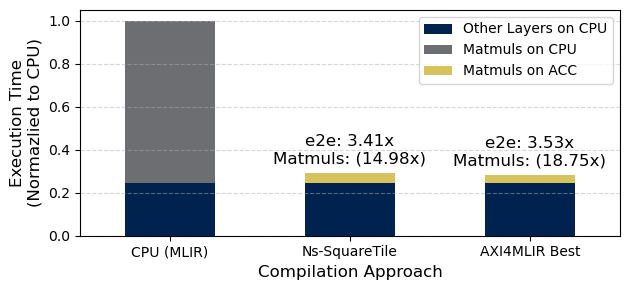

In [11]:
experiment = 'tinybert-runtime'
figure_size = (6.4, 3)
# ==============================================================================

figure_name = 'output/{}.{}'.format(experiment, figure_fmt)
figure_path = os.path.join(os.getcwd(), figure_name)


data = pd.DataFrame(out_dict)

# # make index: compilation approach
data = data.set_index('Compilation Approach')

# # Devide all values by the sum of 'CPU (MLIR)' row as long it is not the Compilation Approach column
data = data.divide(data.iloc[0].sum(), axis=1)

# Remove row Cs-SquareTile
data = data.drop(index=['Cs-SquareTile'])


# plot stacked bar chart
ax = data.plot.bar(cmap=new_cmap, stacked=True, figsize=figure_size, rot=0)

# Anotate bars with speedup, use enumerate to get index to filter out the first bar
for i, p in enumerate(ax.patches):
    # if (i > 6) | (i==3):
    if (i > 6):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        # Provides the total:
        # ax.annotate('{:.3f}'.format(y+height), (x + width/2, y + height/2), ha='center', va='center', fontsize=12)

        # Provides speedup
        # ax.annotate('{:.2f}x\n({:.2f}x)'.format(1/(y+height),), (x + width/2, (y + height)*1.1), ha='center', va='bottom', fontsize=12)
        ax.annotate('e2e: {:.2f}x\nMatmuls: ({:.2f}x)'.format(1/(y+height),.75/height), (x + width/2, (y + height)*1.1), ha='center', va='bottom', fontsize=12)

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylabel('Execution Time\n(Normazlied to CPU)')

if figure_save:
    plt.savefig(figure_path, format=figure_fmt)
plt.show()
